In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from numpy.linalg import norm

In [2]:
import sys
sys.path.append("./Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs

In [3]:
n_321g=gto.basis.load(bse.get_basis("6-31G",fmt="nwchem",elements=["N"]),"N")
c_321g=gto.basis.load(bse.get_basis("6-31G",fmt="nwchem",elements=["C"]),"C")
n_321g,"*******************",c_321g

([[0,
   [4173.51146, 0.00183477216],
   [627.457911, 0.013994627],
   [142.902093, 0.06858655181],
   [40.2343293, 0.232240873],
   [12.8202129, 0.4690699481],
   [4.39043701, 0.3604551991]],
  [0,
   [11.62636186, -0.1149611817],
   [2.716279807, -0.1691174786],
   [0.7722183966, 1.145851947]],
  [0, [0.2120314975, 1.0]],
  [1,
   [11.62636186, 0.06757974388],
   [2.716279807, 0.3239072959],
   [0.7722183966, 0.7408951398]],
  [1, [0.2120314975, 1.0]]],
 '*******************',
 [[0,
   [3047.52488, 0.001834737132],
   [457.369518, 0.01403732281],
   [103.948685, 0.06884262226],
   [29.2101553, 0.2321844432],
   [9.28666296, 0.4679413484],
   [3.16392696, 0.3623119853]],
  [0,
   [7.86827235, -0.1193324198],
   [1.88128854, -0.1608541517],
   [0.544249258, 1.143456438]],
  [0, [0.1687144782, 1.0]],
  [1,
   [7.86827235, 0.06899906659],
   [1.88128854, 0.316423961],
   [0.544249258, 0.7443082909]],
  [1, [0.1687144782, 1.0]]])

Per gli orbitali "s" vale la formula $<g_ig_j>=c_i^2+c_j^2+c_ic_j*(2\sqrt{a_ia_j}/(a_i+a_j))^{3/2}$

In [4]:
0.4133000774**2+ 1.224417267**2 -2*0.4133000774*1.224417267*(2*(5.42522*1.14915)**.5/(5.42522+1.14915))**(3/2)

1.0000000003075527

In [5]:
1.215834356**2+0.3958951621**2 -2*1.215834356*0.3958951621*(2*(3.66498*0.770545)**.5/(3.66498+0.770545))**(3/2)

1.000000000624618

Per gli orbitali "p" vale la formula $<g_ig_j>=c_i^2+c_j^2+c_ic_j*(2\sqrt{a_ia_j}/(a_i+a_j))^{5/2}$

In [6]:
0.2364599466**2+0.8606188057**2 +2*0.2364599466*0.8606188057*(2*(3.66498*0.770545)**.5/(3.66498+0.770545))**(5/2)

0.999999999942027

In [7]:
c_321=gto.basis.load(bse.get_basis("6-31G",fmt="nwchem",elements=["C"]),"C")
o_321=gto.basis.load(bse.get_basis("6-31G",fmt="nwchem",elements=["O"]),"O")
f_321=gto.basis.load(bse.get_basis("6-31G",fmt="nwchem",elements=["F"]),"F")

In [8]:
f_321

[[0,
  [7001.71309, 0.001819616901],
  [1051.36609, 0.01391607961],
  [239.28569, 0.06840532453],
  [67.3974453, 0.2331857601],
  [21.5199573, 0.4712674392],
  [7.4031013, 0.3566185462]],
 [0,
  [20.8479528, -0.1085069751],
  [4.80830834, -0.1464516581],
  [1.34406986, 1.128688581]],
 [0, [0.358151393, 1.0]],
 [1,
  [20.8479528, 0.07162872424],
  [4.80830834, 0.3459121027],
  [1.34406986, 0.7224699564]],
 [1, [0.358151393, 1.0]]]

In [9]:
def g321(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("6-31G",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=g321(ref)
        rbm=g321(ref-1)
        rbp=g321(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  
            for j in range(1,len(fb[i])):
                a=(rbp[i][j][0]-rbm[i][j][0])/2
                b=(rbp[i][j][0]+rbm[i][j][0]-2*rb[i][j][0])
                fb[i][j][0]+=a*(z-ref)+b*(z-ref)**2
                a=(rbp[i][j][1]-rbm[i][j][1])/2
                b=(rbp[i][j][1]+rbm[i][j][1]-2*rb[i][j][1])
                fb[i][j][1]+=a*(z-ref)+b*(z-ref)**2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [10]:
g321(6,ref=6),g321(6.5,ref=6),g321(7,ref=6)

([[0,
   [3047.52488, 0.001834737132],
   [457.369518, 0.01403732281],
   [103.948685, 0.06884262226],
   [29.2101553, 0.2321844432],
   [9.28666296, 0.4679413484],
   [3.16392696, 0.3623119853]],
  [0,
   [7.86827235, -0.1193324198],
   [1.88128854, -0.1608541517],
   [0.544249258, 1.143456438]],
  [0, [0.1687144782, 1.0]],
  [1,
   [7.86827235, 0.06899906659],
   [1.88128854, 0.316423961],
   [0.544249258, 0.7443082909]],
  [1, [0.1687144782, 1.0]]],
 [[0,
   [3610.51817, 0.001834754646],
   [542.4137145, 0.014015974905],
   [123.425389, 0.068714587035],
   [34.7222423, 0.2322126581],
   [11.05343793, 0.46850564825],
   [3.7771819850000004, 0.3613835922]],
  [0,
   [9.747317104999999, -0.11714680075],
   [2.2987841734999996, -0.16498581515],
   [0.6582338273, 1.1446541925]],
  [0, [0.19037298785, 1.0]],
  [1,
   [9.747317104999999, 0.068289405235],
   [2.2987841734999996, 0.32016562844999996],
   [0.6582338273, 0.74260171535]],
  [1, [0.19037298785, 1.0]]],
 [[0,
   [4173.51146, 0.00

In [11]:
def E(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7,ref=7),"N2":g321(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

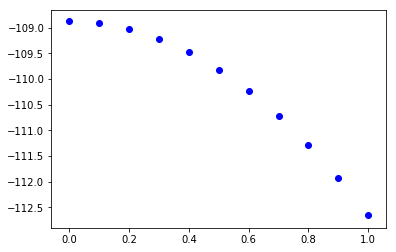

In [12]:
for i in np.linspace(0,1,11):
    plt.scatter(i,E(i),color="blue")

In [13]:
eT_R=E(-1,zbs=False)

In [14]:
e_co=scf.RHF(gto.M(atom="C 0 0 0; O 0 0 2.05",unit="Bohrs",basis=bse.get_basis("6-31G"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()
e_nn=scf.RHF(gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("6-31G"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()

converged SCF energy = -112.661562568708
converged SCF energy = -108.867942022953


In [15]:
#5pts finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

In [31]:
dl=.1
Es=np.asarray([E(-3*dl),E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl),E(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft,e_co,inc

([-108.86794202295306,
  -108.86794202295178,
  -112.67309394419593,
  -112.67309394425602,
  -112.64355278556049,
  -112.64355278504534,
  -112.66227068411803],
 -112.66156256870833,
 [1.2723155862204294e-12,
  -3.8051519212441534,
  -6.010007306637512e-11,
  0.029541158695541483,
  5.151434834260725e-10,
  -0.018717899072681923])

In [17]:
dl=.1
Es=np.asarray([E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl)])
apdft=[e_nn]
inc=[]
for i in range(4):
    inc.append(fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,e_co,inc

([-108.86794202295306,
  -108.86794202295356,
  -112.67308645703551,
  -112.67308645702603,
  -112.64448119344004],
 -112.66156256870833,
 [-4.973799150320701e-13,
  -3.805144434081952,
  9.473903143468e-12,
  0.02860526358598273])

In [18]:
dl=.05
Es=np.asarray([E(-3*dl,zbs=False),E(-2*dl,zbs=False),E(-dl,zbs=False),e_nn,E(dl,zbs=False),E(2*dl,zbs=False),E(3*dl,zbs=False)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,eT_R,e_co,inc

([-108.86794202295306,
  -108.86794202295361,
  -110.77224891304294,
  -110.77224891322058,
  -110.7967124657554,
  -110.79671245760785,
  -110.79950872559539],
 -110.79939201680024,
 -112.66156256870833,
 [-5.551115123125783e-13,
  -1.9043068900893352,
  -1.7763568394002502e-10,
  -0.02446355253482579,
  8.147556703382481e-09,
  -0.002796267987529668])

In [23]:
def E_cn(l):
    mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

In [22]:
mf_cn=scf.RHF(gto.M(atom="C 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("6-31G"\
                                                       ,fmt="nwchem",elements=["C","N","O"]),charge=-1))
e_cn=mf_cn.scf()

converged SCF energy = -92.2174104946118


In [25]:
dl=.1
Es=np.asarray([E_cn(-3*dl),E_cn(-2*dl),E_cn(-dl),e_nn,E_cn(dl),E_cn(2*dl),E_cn(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
apdft,e_cn,apdft-e_cn

(array([-108.86794202,  -90.62570208,  -92.26553671,  -92.21458159,
         -92.20807365,  -92.20731339,  -92.20740681]),
 -92.21741049461178,
 array([-1.66505315e+01,  1.59170842e+00, -4.81262194e-02,  2.82890285e-03,
         9.33684609e-03,  1.00971002e-02,  1.00036799e-02]))

In [26]:
#check if basis are orthonormal

In [27]:
def S(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7,ref=7),"N2":g321(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    #e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return mf_l.get_ovlp()

In [28]:
for i in np.linspace(0,1,7):
    print(S(i).diagonal())  #automatic normalization

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


(<matplotlib.image.AxesImage at 0x7f7e3cdeb278>,
 <matplotlib.image.AxesImage at 0x7f7e3cbaf2e8>)

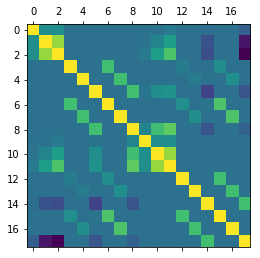

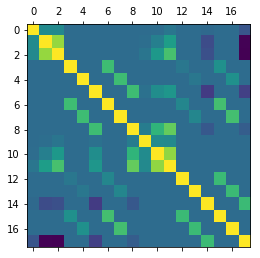

In [55]:
plt.matshow(S(0)),plt.matshow(S(.5))